#### Modelling Options using a Jump Diffusion Model

Assuming the asset price evolves according to a jump diffusion model, Merton (1976) suggests the price of a European option one day later can be obtained as follows:
$$S_{t+1}=S_t*exp[(r-\xi-\lambda y-\frac{\sigma^2}{2})\frac{1}{365}+(\sigma\sqrt{\frac{1}{365}})z_1]*exp[\frac{n\gamma}{365}+(\delta\sqrt{\frac{n}{365}})z_2]$$
$z_1$ is a number from the standard normal that determines stochastic vibrations related to the normal stochastic process

$z_2$ is a number from the standard normal that determines stochastic vibrations related to the jump component of the stochastic process

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal


In [3]:
def jump_diffusion(num_sims=10, dte=90, s=100, r=0.06, xi=0, lmbda=0.1, y=-0.1, sigma=0.25, delta=0.25):
    """
    Runs a monte carlo simulation under the jump diffusion model

    num_sims: number of simulations
    dte: initial dates to expiry
    s: initial price
    r: risk-free rate
    xi: dividend yield
    lmbda: rate of jumps, equal to the expected number of jumps in 365 days
    y: expected jump size
    sigma: normal return volatility
    delta: volatility of the jump size

    Returns: list of all the final price of each simulation (0 days to expiry)
    """
    #tau: time increment
    tau = 1/365
    
    sim = np.zeros(shape=[num_sims, dte+1])
    sim[:, 0] = s  # initialize all simulations to the intial price

    gamma = np.log(1+y)

    # z1: random number from standard normal that determines stochastic vibrations related to normal stochastic process
    z1 = np.random.normal(size=[num_sims, dte])

    # z2: random number from standard normal that determines stochastic vibrations related to jump component of stochastic process
    z2 = np.random.normal(size=[num_sims, dte])

    # n: number of jumps during life of option, poisson distributed with parameter lambda(1+y)tau
    n = np.random.poisson(lmbda*(1+y)*tau, size=[num_sims, dte])

    for t in range(dte):
        sim[:, t + 1] = sim[:, t] * np.exp(
            (r - xi - lmbda * y - sigma ** 2 / 2) * tau \
            + sigma * np.sqrt(tau) * z1[:, t] \
            + n[:, t]*gamma*tau \
            + delta * np.sqrt(n[:, t]*tau)*z2[:, t])

    plt.axes().set(xlabel='Days to Expiry', ylabel='Share Price ($)')
    plt.plot(np.linspace(dte, 0, dte+1), sim.T)
    plt.xlim(dte, 0)
    return sim[:,-1]

In [95]:
def estimate_params(ticker = "CCL",year = 2020, no_jumps = False):
    year_to_fileyear_dict = {2018:1, 2019:2, 2020:3, 2021:4, 2022:5}
    fileyear = year_to_fileyear_dict[year]
    tickers_df = pd.read_csv("data/equity-data-5-years/SP500-Tickers.csv")
    index = np.where(tickers_df["Symbol"] == ticker)[0][0] + 1
    path = "data/equity-data-5-years/Year-" + str(fileyear) + "/Firm-" + str(index) + ".csv"
    df = pd.read_csv(path)
    final_price = df.volume_weighted_average_price.tail(1).item()
    initial_price = df.volume_weighted_average_price.head(1).item()
    log_returns = np.log(df.volume_weighted_average_price) - np.log(df.volume_weighted_average_price.shift(1))
    log_returns = log_returns[~np.isnan(log_returns)].reset_index(drop = True)
    
    #Fit parameters without jumps
    if no_jumps:
        num_days = log_returns.size
        one_day_vol = log_returns.std()
        sigma = one_day_vol * np.sqrt(365) #annualized volatility
        return {"num_days": num_days, "initial_price":initial_price, "sigma":sigma, "lambda":0, "y":0, "delta":0}

    #Fit parameters with jumps
    zscores = stats.zscore(log_returns)
    outlier_indices = np.where(abs(zscores)>=2)[0]
    outliers = log_returns[outlier_indices].to_numpy()
    num_days = log_returns.size
    lmbda = 365 * outliers.size / log_returns.size
    y = outliers.mean()
    delta = outliers.std() * np.sqrt(365)
    sigma = log_returns.std() * np.sqrt(365)
    s = df['volume_weighted_average_price'][0]
    return {"num_days": num_days, "initial_price":initial_price, "sigma":sigma, "lambda":lmbda, "y":y, "delta":delta}
print(estimate_params(no_jumps = True))
print(estimate_params(no_jumps = False))

{'num_days': 251, 'initial_price': 49.9282, 'sigma': 1.3290666381233591, 'lambda': 0, 'y': 0, 'delta': 0}
{'num_days': 251, 'initial_price': 49.9282, 'sigma': 1.3290666381233591, 'lambda': 24.721115537848604, 'y': -0.02004659164733517, 'delta': 4.014347997412623}


In [118]:
def to_market_day(year, month, date):
  nyse = mcal.get_calendar('NYSE')
  schedule = nyse.schedule(start_date = f'{year}-01-01', end_date = f'{year}-12-31')
  schedule["dates"] = schedule.index
  schedule.reset_index(drop = True, inplace = True, names = "dates")
  return schedule[schedule.dates==f"{year}-{month}-{date}"].index[0] + 1 #ranges from 1 to 252

array([206.927323  ,  69.80894044, 325.57340339,  69.63548925,
        87.69485608,  64.21059569, 213.3093176 , 162.91362035,
       137.71469047, 108.53435051, 236.03591989, 140.19303913,
       232.53263075, 167.13155422, 254.60450501, 105.83770469,
       471.23424907, 386.4007952 , 287.2881574 ,  71.82826341,
       200.72541611, 146.8551355 , 306.44205209, 132.51783564,
       162.32151749, 210.37574213, 141.54688721, 147.70660968,
       197.63129787, 229.07693318, 309.42218449, 169.48077934,
       154.86452079, 186.82545793, 240.80022801, 245.54578374,
       110.76297835, 262.75297856, 285.59648207, 204.46973143,
       162.38336549, 150.36543951, 237.32543462, 116.05681348,
       321.5150243 , 119.36691089,  98.53237925, 308.34217402,
       272.9662883 , 111.54429428, 192.82824578, 229.3577606 ,
       190.78352035,  88.81496197, 114.43311748, 594.41871026,
       163.67727188, 146.16224121, 260.30295668, 177.33100056,
        81.59881847, 171.72876833, 190.3552126 , 252.63

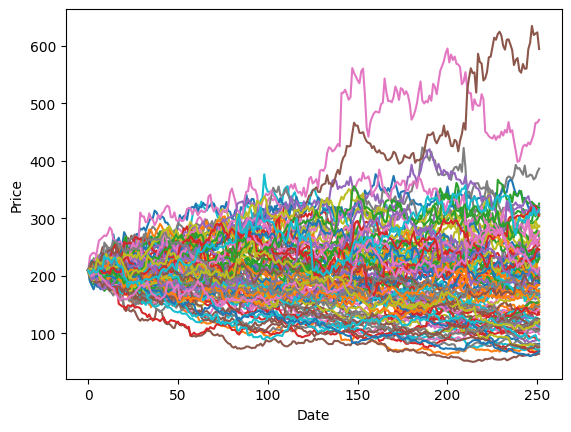

In [136]:
def jump_diffusion_with_earnings(ticker, year, no_jumps = False, num_sims = 10):
    """
    Runs a monte carlo simulation under the jump diffusion model with the addition of earnings

    ticker: ticker of the smp 500 stock
    year: year ranging from 2018-2022 inclusive
    no_jumps: whether or not to estimate paramaters with jumps
    num_sims: number of simulations

    Returns: list of all the final price of each simulation
    """
    params = estimate_params(ticker = ticker, year = year, no_jumps = no_jumps)
    dte = params["num_days"]
    s = params["initial_price"]
    y = params["y"]
    sigma = params["sigma"]
    lmbda = params["lambda"]
    delta = params["delta"]
    r = 0.06
    xi = 0
    
    #tau: time increment
    tau = 1/365
    
    sim = np.zeros(shape=[num_sims, dte+1])
    sim[:, 0] = s  # initialize all simulations to the intial price

    gamma = np.log(1+y)

    # z1: random number from standard normal that determines stochastic vibrations related to normal stochastic process
    z1 = np.random.normal(size=[num_sims, dte])

    # z2: random number from standard normal that determines stochastic vibrations related to jump component of stochastic process
    z2 = np.random.normal(size=[num_sims, dte])

    # n: number of jumps during life of option, poisson distributed with parameter lambda(1+y)tau
    n = np.random.poisson(lmbda*(1+y)*tau, size=[num_sims, dte])

    #Calculate earnings and add jumps
    earnings_df = yf.Ticker(ticker).get_earnings_dates(30)
    date_tuples = list(map(lambda date: (date.year,date.month,date.day), pd.to_datetime(earnings_df.index)))
    date_tuples = list(filter(lambda tup: tup[0]==year, date_tuples))[::-1]
    jump_times=[]
    for tup in date_tuples:
        jump_times.append(to_market_day(*tup))
    for jump_time in jump_times:
        n[:, jump_time] += 1

    
    for t in range(dte):
        sim[:, t + 1] = sim[:, t] * np.exp(
            (r - xi - lmbda * y - sigma ** 2 / 2) * tau \
            + sigma * np.sqrt(tau) * z1[:, t] \
            + n[:, t]*gamma*tau \
            + delta * np.sqrt(n[:, t]*tau)*z2[:, t])
    plt.axes().set(xlabel='Date', ylabel='Price')
    plt.plot(np.linspace(0, dte, dte+1), sim.T)
    return sim[:,-1]
jump_diffusion_with_earnings(ticker="FB", year = 2020, no_jumps = False, num_sims = 100)

array([174.28085591, 247.3395812 , 196.68354883, 188.36833703,
       483.36592994, 299.21139691,  97.09593981, 363.7256402 ,
       215.30449882, 165.08090363, 166.68481265,  83.31446983,
       143.77313533, 459.59572593, 227.25415792, 146.22330014,
       180.61542192, 217.91519219, 201.46553222, 371.15098807,
       199.40715752, 161.91889769, 215.47225768, 184.62368725,
       157.55024412, 215.66147686,  81.87365193, 128.40603247,
       187.45570538, 246.49865448, 261.70224165, 287.98807498,
       122.53127134, 223.55592963, 215.40955669, 304.78093138,
       172.28435097, 231.89071325, 182.14445401, 386.24740177,
       202.53883458, 177.29367856, 172.18988389, 255.40301113,
       217.94324381, 189.39967405, 283.59291344, 203.10152252,
       136.27956604, 211.87711481, 193.87076538, 165.55734662,
       283.40235173, 161.56020972, 287.4026271 , 293.5247373 ,
       289.42318546, 169.8200849 , 127.37582618, 136.32374154,
       236.8537398 , 138.37323644, 137.93538299, 342.10

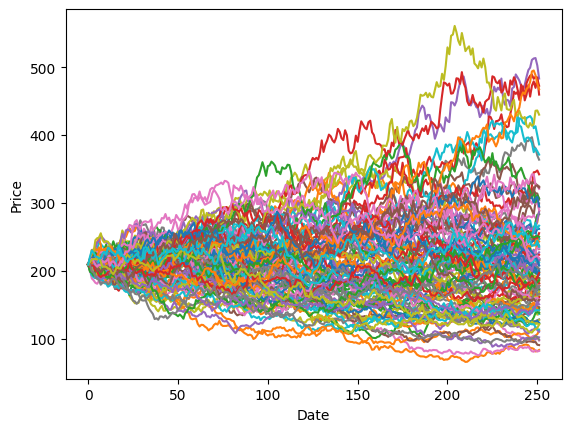

In [135]:
jump_diffusion_with_earnings(ticker="FB", year = 2020, no_jumps = True, num_sims = 100)

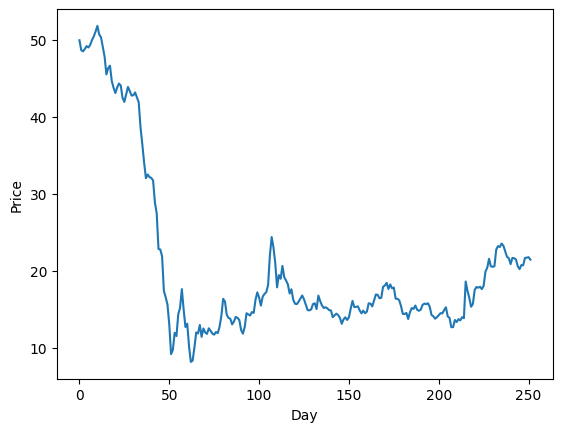

In [126]:
ticker = "CCL"
year = 2020

year_to_fileyear_dict = {2018:1,2019:2,2020:3,2021:4,2022:5}
fileyear = year_to_fileyear_dict[year]
tickers_df = pd.read_csv("data/equity-data-5-years/SP500-Tickers.csv")
index = np.where(tickers_df["Symbol"] == ticker)[0][0] + 1
path = "data/equity-data-5-years/Year-" + str(fileyear) + "/Firm-" + str(index) + ".csv"
df = pd.read_csv(path)
log_returns = np.log(df.volume_weighted_average_price) - np.log(df.volume_weighted_average_price.shift(1))
log_returns = log_returns[~np.isnan(log_returns)].reset_index(drop = True)
df.plot(y='volume_weighted_average_price', xlabel='Day', ylabel='Price', legend=False)
plt.show()

sigma: 1.3290666381233591


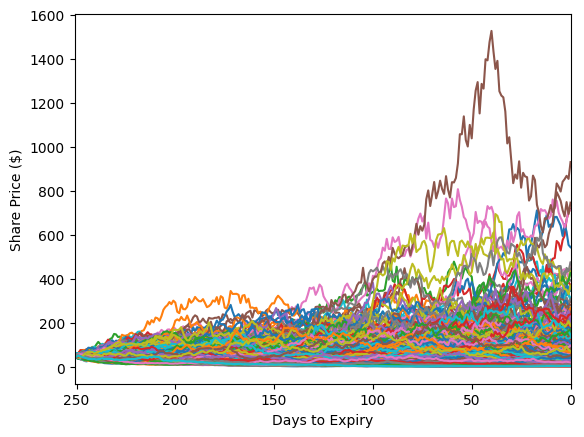

In [90]:
#Fit parameters assuming all jumps are from Brownian motion, so lambda=0
num_days = log_returns.size
one_day_vol = log_returns.std()
sigma = one_day_vol * np.sqrt(365) #annualized volatility
initial_price = df['volume_weighted_average_price'][0]
final_price = df['volume_weighted_average_price'].tail(1).item()
print(f"sigma: {sigma}")
data_without_jumps = jump_diffusion(num_sims=1000, dte=num_days, s=initial_price, r=0.06, xi=0, lmbda=0, y=0, sigma=sigma, delta=0)

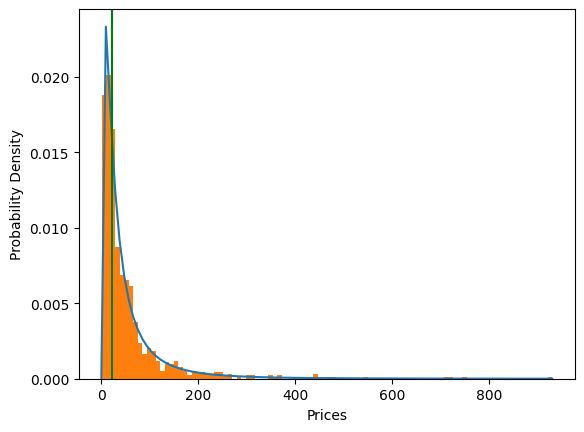

In [91]:
shape, loc, scale = stats.lognorm.fit(data_without_jumps)
x = np.linspace(0, max(data_without_jumps), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)
plt.axes().set(xlabel='Prices', ylabel='Probability Density')
plt.plot(x, pdf)
plt.hist(data_without_jumps, bins=100, density=True)
plt.axvline(x = final_price, color = 'green', label = 'axvline - full height')
plt.show()

lambda: 24.721115537848604
y:-0.02004659164733517
sigma: 1.3290666381233591
delta: 4.014347997412623


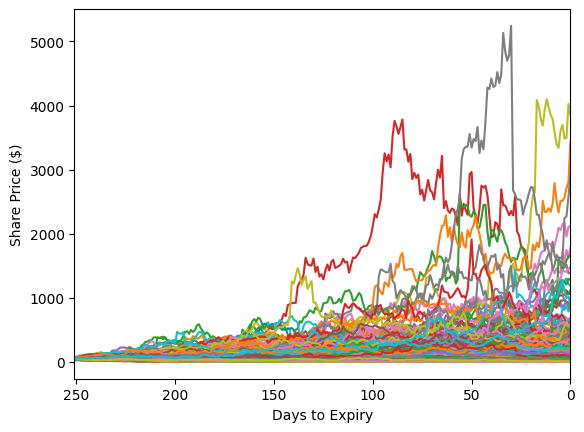

In [92]:
#Fit parameters with jumps
zscores = stats.zscore(log_returns)
outlier_indices = np.where(abs(zscores)>=2)[0]
outliers = log_returns[outlier_indices].to_numpy()

dte = log_returns.size
lmbda = 365 * outliers.size / log_returns.size
y = outliers.mean()
delta = outliers.std() * np.sqrt(365)
sigma = log_returns.std() * np.sqrt(365)
s = df['volume_weighted_average_price'][0]
data_with_jumps = jump_diffusion(num_sims=1000, dte=dte, s=s, r=0.06, xi=0, lmbda=lmbda, y=y, sigma=sigma, delta=delta)
print(f"lambda: {lmbda}\ny:{y}\nsigma: {sigma}\ndelta: {delta}")

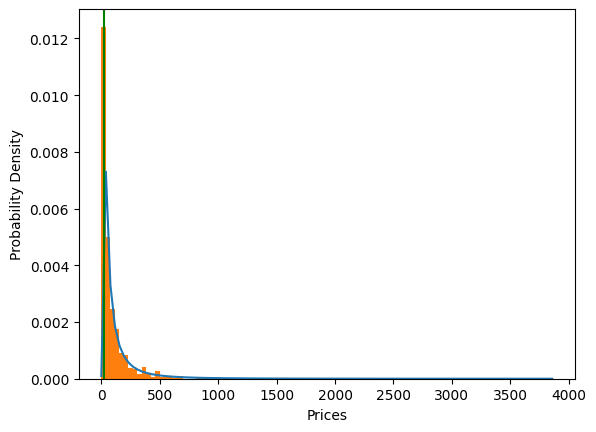

In [93]:
shape, loc, scale = stats.lognorm.fit(data_with_jumps)
fitted_data = stats.lognorm.rvs(shape,loc, scale, size=len(data_with_jumps))
x=np.linspace(0,max(data_with_jumps),100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)
plt.axes().set(xlabel='Prices', ylabel='Probability Density')
plt.plot(x, pdf)
plt.hist(data_with_jumps, bins=100, density=True)
plt.axvline(x = final_price, color = 'green', label = 'axvline - full height')
plt.show()

In [ ]:
#TODO calculate z-score for actual price using both log-normals, see which one's better
